# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

# Printing the numbers of row and columns of the azdias and feat_info datasets (i.e. shape)
print("Shape of AZDIAS data is {}".format(azdias.shape))
print("Shape of Feature Summary data is {}".format(feat_info.shape))



Shape of AZDIAS data is (891221, 85)
Shape of Feature Summary data is (85, 4)


In [4]:
# Retrieving data info for AZDIAS
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [5]:
# Displaying the first 10 rows of AZDIAS
display(azdias.head(n=5))

# displaying the Feat_info data
display(feat_info)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [6]:
# Identify missing or unknown data values and convert them to NaNs.

for feat in range(len(feat_info)):
    missing = feat_info.iloc[feat][3]
    missing = missing.strip('[').strip(']').split(sep=',')
    missing = [int(val) if (val!='' and val!='X' and val!='XX') else val for val in missing]
    if missing != ['']:
        azdias = azdias.replace({feat_info.iloc[feat][0]: missing}, np.nan)


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [7]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
print(azdias.isnull().sum())


AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

Number of Features WITH NaNs = 61
Number of Features WITHOUT NaNs = 24
Distribution of NaN values


(array([ 25.,   6.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   5.,   2.,   0.,   0.,   5.,   9.,
          4.,   1.,   2.,   3.,   7.,   0.,   0.,   6.,   0.,   0.,   0.,
          1.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

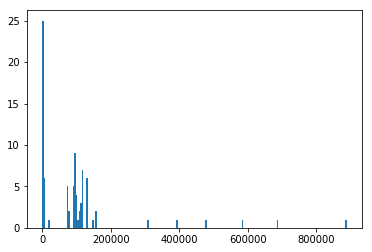

In [8]:
# Investigate patterns in the amount of missing data in each column.

# Number of variables without NaNs
print("Number of Features WITH NaNs = {}".format(np.count_nonzero(azdias.isnull().sum())))

# Number of variables with NaNs
print("Number of Features WITHOUT NaNs = {}".format(len(azdias.isnull().sum()) - np.count_nonzero(azdias.isnull().sum())))

# Plotting histogram to check distribution of outliers
n_bins = 200
print("Distribution of NaN values")
plt.hist(azdias.isnull().sum(), bins=n_bins)

In [9]:
# Retrieve the variables that contain NaN
feat_notnan = azdias.isnull().sum()
feat_notnan = feat_notnan[feat_notnan>0].index.tolist()
print("Features WITH NaN values:")
print(feat_notnan)

Features WITH NaN values:
['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'CJT_GESAMTTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_BAUMAX', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_HHZ', 'PLZ8_GBZ', 'ARBEIT', 'ORTSGR_KLS9', 'RELAT_AB

In [10]:
# Retrieve the variables that does not contain NaN

feat_nan = azdias.isnull().sum()
feat_nan = feat_nan[feat_nan==0].index.tolist()
print("Features WITHOUT NaN values:")
print(feat_nan)

Features WITHOUT NaN values:
['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GREEN_AVANTGARDE', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'ZABEOTYP']


In [11]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# Variables (or columns) with more than outlier_thres missing values are considered outliers and will be removed
outlier_feat_thres = 200000
feat_nan = azdias.isnull().sum()
outlier_feat = feat_nan[feat_nan>outlier_feat_thres].index.tolist()

print("Outlier features with NaN values > threshold: {}".format(outlier_feat))

# Excluding Columns Outliers
azdias_1 = azdias.drop(columns=outlier_feat)

# Excluding Outliers in Feature_Info
ind = np.in1d(feat_info['attribute'],outlier_feat)        
feat_info_1 = feat_info.drop(index=feat_info.index[ind], axis=0)

print(azdias_1.shape, feat_info_1.shape)


Outlier features with NaN values > threshold: ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
(891221, 79) (79, 4)


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

Response:
   It was identified 61 out of 85 features (columns) in the General Demographic data that contain missing values. Interestingly, features within the same group have the same ammount of missing values, e.g.; KBA05_ANTG*, CAMEO_* and PLZ8_ANTG*.
   The distribution of missing values in the features shows that most of the features contain between 100,000 and 200,000 missing values. Removing features with relatively large ammoung of missing values is important to avoid keeping non-informative features in the data. However, due to the large number of features containing missing values, the conservative approach of simply removing all of them from the data impacts on relevant loss of information that is important to complete the goals of the project.
   Therefore, a trade-off between removing features with excessive missing values, and at the same time avoiding significantly loss of important information from the features was decided by excluding the features containing more than 200,000 missing values, which are: ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']



#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

(array([  6.23209000e+05,   1.57380000e+04,   2.79260000e+04,
          1.76290000e+04,   1.26070000e+04,   2.25150000e+04,
          1.37710000e+04,   1.37140000e+04,   2.45920000e+04,
          3.04200000e+03,   5.41000000e+03,   1.12700000e+03,
          7.66000000e+02,   3.25500000e+03,   2.24300000e+03,
          4.74300000e+03,   2.50500000e+03,   6.77000000e+02,
          4.28000000e+02,   1.18000000e+03,   3.49000000e+02,
          1.50000000e+02,   1.29000000e+02,   1.32000000e+02,
          6.90000000e+01,   5.50000000e+01,   5.90000000e+01,
          2.40000000e+01,   5.00000000e+00,   1.20000000e+01,
          6.00000000e+00,   3.00000000e+00,   2.06000000e+02,
          2.98500000e+03,   1.08160000e+04,   3.91100000e+03,
          8.40000000e+01,   5.38000000e+02,   4.21000000e+02,
          7.70000000e+01,   1.37000000e+02,   3.56000000e+02,
          2.10000000e+01,   2.73690000e+04,   1.55000000e+02,
          4.94000000e+02,   0.00000000e+00,   4.55780000e+04,
        

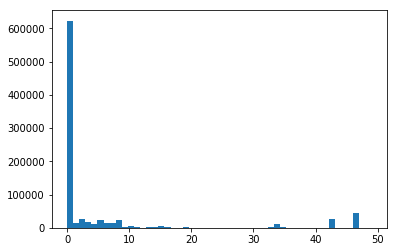

In [12]:
# How much data is missing in each row of the dataset?

num_nan_row = azdias_1.isnull().sum(axis=1)

plt.hist(num_nan_row, bins=50)

In [13]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

num_nan_threshold = 5

# Data containing rows with number of NaNs EQUAL or BELOW the threshold
azdias_2below = azdias_1[azdias_1.isnull().sum(axis=1) <= num_nan_threshold]

# Printing shape of the selecte data
print("Shape of the azdias_2below data is {}".format(azdias_2below.shape))
# printing the number of excluded rows
n_rowsout = (azdias_1.shape[0] - azdias_2below.shape[0])
print("Number of excluded rows using NaN threshold equal to {} is {}".format(num_nan_threshold, n_rowsout))

# Data containing rows with number of NaNs ABOVE the threshold
azdias_2above = azdias_1[azdias_1.isnull().sum(axis=1) > num_nan_threshold]

#Sanity check the dimensions are OK
print("Shape of the excluded data (azdias_2above) is {}".format(azdias_2above.shape))

Shape of the azdias_2below data is (719624, 79)
Number of excluded rows using NaN threshold equal to 5 is 171597
Shape of the excluded data (azdias_2above) is (171597, 79)


In [14]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# Building the function
def plot_dist(data1, data2, variables):
    
    for var in variables:
        fig, ax = plt.subplots(1, 2)
        sns.countplot(data1[var], ax=ax[0])
        sns.countplot(data2[var], ax=ax[1])
    

In [15]:
# Num of NaNs per column after exclusing rows with number of NaNs > num_nan_threshold
X = azdias_2below
X = X[X.isnull().sum()[X.isnull().sum()>0].index.tolist()]
#Printing number of NaN per column 
print("Features WITH NaNs, number of NaNs:")
print(X.isnull().sum().sort_values(ascending=False))

# Variables without any NaN after the outlier filtering
X = azdias_2below
X = X[X.isnull().sum()[X.isnull().sum()==0].index.tolist()]
#Printing number of NaN per column 
print("Features WITHOUT NaNs, number of NaNs:")
print(X.isnull().sum().sort_values(ascending=False))

Features WITH NaNs, number of NaNs:
W_KEIT_KIND_HH           39782
REGIOTYP                 38742
KKK                      38742
LP_LEBENSPHASE_FEIN      19703
LP_LEBENSPHASE_GROB      19576
LP_FAMILIE_GROB          19575
LP_FAMILIE_FEIN          19575
VERS_TYP                 14810
SHOPPER_TYP              14810
HEALTH_TYP               14810
NATIONALITAET_KZ         13279
PRAEGENDE_JUGENDJAHRE     7364
ARBEIT                    3607
RELAT_AB                  3607
ORTSGR_KLS9               3531
CAMEO_INTL_2015           3057
CAMEO_DEU_2015            3057
CAMEO_DEUG_2015           3057
ANZ_HAUSHALTE_AKTIV       2645
ALTERSKATEGORIE_GROB      1531
KBA13_ANZAHL_PKW           642
ANZ_HH_TITEL               603
BALLRAUM                   442
EWDICHTE                   442
INNENSTADT                 442
KONSUMNAEHE                 44
GEBAEUDETYP_RASTER           5
dtype: int64
Features WITHOUT NaNs, number of NaNs:
PLZ8_GBZ                 0
PLZ8_HHZ                 0
SEMIO_KRIT           

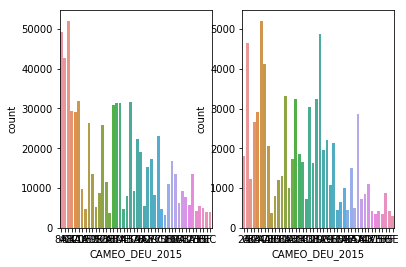

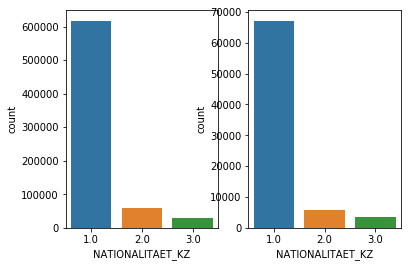

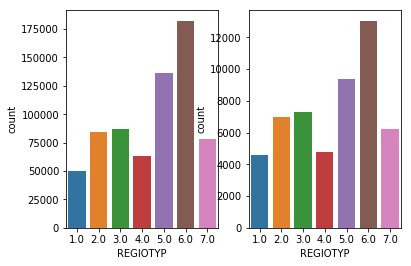

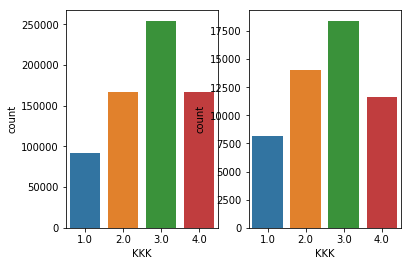

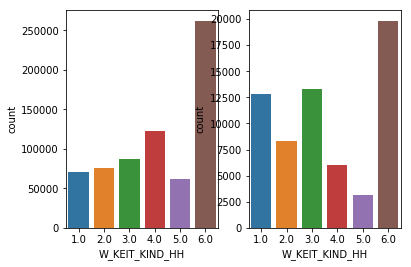

In [16]:
# Checking the distribution of selected variables between the subsets (no/few outliers versus many outliers)

plot_dist(azdias_2below, azdias_2above, ["CAMEO_DEU_2015","NATIONALITAET_KZ","REGIOTYP","KKK","W_KEIT_KIND_HH"])

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

Response:
    After removing the features with relatively large ammount of missing values, the inspection of missing values in the rows shows that most of the rows contain up to 20 missing values in their features. Considering that missing values will have to be imputed later, it is very important to avoid rows with too many missing values, because data imputation changes the data, and therefore there is always a risk of getting incorrect interpretation of the unsupervised models later if the data is largely modified by imputation.
    Therefore, it was allowed in the data only rows containing no more than 5 missing values (i.e. ~6%), which resulted in the exclusion of 171597 (~ 23.8%) out of 719624 rows. This decision was also supported by the fact that the number of remaining rows is still large enough for the unsupervised modelling that will address to the project's goal.
    The analysis of the distribution of the features after outlier removal in both columns and rows dimensions reveals some quite relevant discrepancies among the same features between the 2 subsets of the data containing no/less missing values versus with many missing values, paticularly for the features with larger number of missing values still persisting, such as "W_KEIT_KIND_HH" (they will be replaced later). 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [17]:
# How many features are there of each data type?

# Getting variables in feat_info that remained in the data after outlier removal (rows and columns)

feat_info_1.groupby(by='type').count()

,attribute,information_level,missing_or_unknown
type,,,
categorical,18,18,18
mixed,6,6,6
numeric,6,6,6
ordinal,49,49,49


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [18]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

catvars = feat_info_1[feat_info_1['type']=='categorical'].attribute
X = azdias_2below[catvars]
for catvar in catvars:
    print("Number of levels for the categorical feature {} is {}".format(catvar, X[catvar].value_counts().count()))


Number of levels for the categorical feature ANREDE_KZ is 2
Number of levels for the categorical feature CJT_GESAMTTYP is 6
Number of levels for the categorical feature FINANZTYP is 6
Number of levels for the categorical feature GFK_URLAUBERTYP is 12
Number of levels for the categorical feature GREEN_AVANTGARDE is 2
Number of levels for the categorical feature LP_FAMILIE_FEIN is 11
Number of levels for the categorical feature LP_FAMILIE_GROB is 5
Number of levels for the categorical feature LP_STATUS_FEIN is 10
Number of levels for the categorical feature LP_STATUS_GROB is 5
Number of levels for the categorical feature NATIONALITAET_KZ is 3
Number of levels for the categorical feature SHOPPER_TYP is 4
Number of levels for the categorical feature SOHO_KZ is 2
Number of levels for the categorical feature VERS_TYP is 2
Number of levels for the categorical feature ZABEOTYP is 6
Number of levels for the categorical feature GEBAEUDETYP is 7
Number of levels for the categorical feature OST_WE

In [19]:
# Access LEVELS of categorical variables with BINARY levels
print("Categorical variables with BINARY levels:")
for catvar in catvars:
    if int(X[catvar].value_counts().count()) == 2:
        print(catvar, X[catvar].unique())
print(' ')
print("Categorical variables with MULTI levels:")        
# Access LEVELS of categorical Multilevel variables
for catvar in catvars:
    if int(X[catvar].value_counts().count()) > 2:
        print(catvar, X[catvar].unique())        
        

Categorical variables with BINARY levels:
ANREDE_KZ [2 1]
GREEN_AVANTGARDE [0 1]
SOHO_KZ [ 1.  0.]
VERS_TYP [  2.   1.  nan]
OST_WEST_KZ ['W' 'O']
 
Categorical variables with MULTI levels:
CJT_GESAMTTYP [ 5.  3.  2.  4.  1.  6.]
FINANZTYP [1 5 2 4 6 3]
GFK_URLAUBERTYP [ 10.   5.   1.  12.   9.   3.   8.  11.   4.   7.   2.   6.]
LP_FAMILIE_FEIN [  5.   1.  10.   2.  nan   7.  11.   8.   4.   6.   9.   3.]
LP_FAMILIE_GROB [  3.   1.   5.   2.  nan   4.]
LP_STATUS_FEIN [  2.   3.   4.   1.  10.   8.   9.   5.   6.   7.]
LP_STATUS_GROB [ 1.  2.  5.  4.  3.]
NATIONALITAET_KZ [  1.   2.  nan   3.]
SHOPPER_TYP [  3.   2.   0.   1.  nan]
ZABEOTYP [5 4 1 6 3 2]
GEBAEUDETYP [ 8.  1.  3.  6.  2.  4.  5.]
CAMEO_DEUG_2015 ['8' '4' '6' '2' '1' '9' '5' '3' '7' nan]
CAMEO_DEU_2015 ['8A' '4C' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5D' '9E' '5C' '9B' '2A' '1B'
 '8B' '3D' '7A' nan '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C'
 '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F' '5F' 

In [20]:
# Re-encode categorical variable(s) to be kept in the analysis.

# Selecting Multi-level variables
var_ml = []
for catvar in catvars:
    if int(X[catvar].value_counts().count()) > 2:
        var_ml.append(catvar)        
print("Categorical Multilevel features: {}".format(var_ml))

# Excluding Multi-level variables that cannot be OneHotEncoder
mlvar_to_exclude = ['CAMEO_DEU_2015']
print("Categorical Multilevel feature that WILL NOT be onehotencoded: {}".format(mlvar_to_exclude))

# Excluding variables that cannot be OneHotEncoded
azdias_2below = azdias_2below.drop(columns=mlvar_to_exclude)
ind = np.in1d(feat_info_1['attribute'],mlvar_to_exclude)        
feat_info_1 = feat_info_1.drop(index=feat_info_1.index[ind], axis=0)
print(azdias_2below.shape, feat_info_1.shape)

# Performing OneHotEncoder using pandas.get_dummies
feat_dummies = np.setdiff1d(var_ml,mlvar_to_exclude).tolist()
azdias_2below = pd.get_dummies(azdias_2below, columns=feat_dummies)

# Printing the OneHotEncoded variables
print("Features that were OneHotEncoded: {}".format(feat_dummies))

# Visualizing OneHotEncoded data
display(azdias_2below.head(n=5))
display(azdias_2below.shape)

Categorical Multilevel features: ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
Categorical Multilevel feature that WILL NOT be onehotencoded: ['CAMEO_DEU_2015']
(719624, 78) (78, 4)
Features that were OneHotEncoded: ['CAMEO_DEUG_2015', 'CJT_GESAMTTYP', 'FINANZTYP', 'GEBAEUDETYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP']


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,1,0,0,0,0,1,0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,1,0,0,0,0,0,1,0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,1,0,0,0,0,1,0,0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,1,0,0,0,0,0,0,1,0,0
6,2.0,2,1,5,1,5,4,3,0,2.0,...,0,1,0,0,0,0,0,1,0,0


(719624, 150)

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

Response:
    There are 18 categorical features and 6 mixed features in the data. The levels of the categorical variables were initially  investigated, in order to evaluate the possibility of feature re-enconding. The steering here is to avoid removing features that can play an important role later during the unsupervised analysis, even though this action simplifies the pre-processing. Therefore, all the multi-level categorical features were one-hot-encoded, except for the "CAMEO_DEU_2015", which contains 44 different levels that most likely cannot be all represented in the validation set. This means lack of robustness for the KMeans model later in the project, and therefore "CAMEO_DEU_2015" was removed from the data.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [21]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# Duplicating variables for futher replacement
azdias_2below['GENERATION'] = azdias_2below['PRAEGENDE_JUGENDJAHRE']
azdias_2below['MOVEMENT'] = azdias_2below['PRAEGENDE_JUGENDJAHRE']

# Defining the dictionaries
generation = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
movement = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}

# Replacing values
azdias_2below['GENERATION'].replace(generation, inplace=True)
azdias_2below['MOVEMENT'].replace(movement, inplace=True)

# Dropping original variable
azdias_2below = azdias_2below.drop(columns=['PRAEGENDE_JUGENDJAHRE'])
display(azdias_2below.shape)

(719624, 151)

In [22]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

azdias_2below['WEALTH'] = azdias_2below['CAMEO_INTL_2015']
azdias_2below['LIFE_STYLE'] = azdias_2below['CAMEO_INTL_2015']

# Defining dictionaries
wealth = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
               '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
               '51':5, '52':5, '53':5, '54':5, '55':5}

life_style = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                   '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                   '51':1, '52':2, '53':3, '54':4, '55':5}
# Replacing values
azdias_2below['WEALTH'].replace(wealth, inplace=True)
azdias_2below['LIFE_STYLE'].replace(life_style, inplace=True)

# Dropping original variable
azdias_2below = azdias_2below.drop(columns=['CAMEO_INTL_2015'])
display(azdias_2below.shape)

(719624, 152)

In [23]:
# Displaying MIXED features
print(feat_info_1[feat_info_1['type']=='mixed'].attribute)

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
79              PLZ8_BAUMAX
Name: attribute, dtype: object


In [24]:
# Excluding the other MIXED variables

mix_vars = ['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','WOHNLAGE','PLZ8_BAUMAX']

azdias_2below = azdias_2below.drop(columns=mix_vars)

display(azdias_2below.shape)

(719624, 148)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

Response:
    The mixed features "PRAEGENDE_JUGENDJAHRE" and "CAMEO_INTL_2015" were engineered according to the instructions, and the remaining mixed features were removed from the data due to the higher complexity on handling this type of feature. This action also aims to reduce the chances of disturbing the data with features that are difficult to preprocess correctly.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [25]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Retrieve the final variables that contain NaN
print(azdias_2below.isnull().sum()[azdias_2below.isnull().sum()>0])

ALTERSKATEGORIE_GROB     1531
HEALTH_TYP              14810
VERS_TYP                14810
W_KEIT_KIND_HH          39782
ANZ_HAUSHALTE_AKTIV      2645
ANZ_HH_TITEL              603
KONSUMNAEHE                44
BALLRAUM                  442
EWDICHTE                  442
INNENSTADT                442
GEBAEUDETYP_RASTER          5
KKK                     38742
REGIOTYP                38742
KBA13_ANZAHL_PKW          642
ARBEIT                   3607
ORTSGR_KLS9              3531
RELAT_AB                 3607
GENERATION               7364
MOVEMENT                 7364
WEALTH                   3057
LIFE_STYLE               3057
dtype: int64


In [27]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# Removing variables with numbers of NaNs > 5%
azdias_2below = azdias_2below.drop(columns=['W_KEIT_KIND_HH','KKK','REGIOTYP'])
ind = np.in1d(feat_info_1['attribute'],['W_KEIT_KIND_HH','KKK','REGIOTYP'])        
feat_info_1 = feat_info_1.drop(index=feat_info_1.index[ind], axis=0)
                                            
# OneHotEncoding variable OST_WEST_KZ
azdias_2below = pd.get_dummies(azdias_2below, columns=['OST_WEST_KZ'])

print("Final features in the dataset: {}".format(feat_info_1['attribute'].tolist()))
print("")
print("Features PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 were Engineered")

Final features in the dataset: ['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALL

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [28]:
def clean_data(df, feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for feat in range(len(feat_info)):
        missing = feat_info.iloc[feat][3]
        missing = missing.strip('[').strip(']').split(sep=',')
        missing = [int(val) if (val!='' and val!='X' and val!='XX') else val for val in missing]
        if missing != ['']:
            df = df.replace({feat_info.iloc[feat][0]: missing}, np.nan)
    
    # remove selected columns and rows, ...
    #outlier features
    outlier_cols = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df = df.drop(columns=outlier_feat)
    
    #outlier rows
    df = df[df.isnull().sum(axis=1) <= 5]
    
    # select, re-encode, and engineer column values.    
    feat_onehotenc = ['CAMEO_DEUG_2015', 'CJT_GESAMTTYP', 'FINANZTYP',
                      'GEBAEUDETYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
                      'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP']
    
    # Removing feature that wil not be onehotencoded
    df = df.drop(columns=['CAMEO_DEU_2015'])
    
    # Performing OneHotEncoder
    df = pd.get_dummies(df, columns=feat_onehotenc)
    
    
    # Engineering features
    
    # 'PRAEGENDE_JUGENDJAHRE'
    df['GENERATION'] = df['PRAEGENDE_JUGENDJAHRE']
    df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE']
    generation = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    movement = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}
    df['GENERATION'].replace(generation, inplace=True)
    df['MOVEMENT'].replace(movement, inplace=True)
    df = df.drop(columns=['PRAEGENDE_JUGENDJAHRE'])

    # 'CAMEO_INTL_2015'
    df['WEALTH'] = df['CAMEO_INTL_2015']
    df['LIFE_STYLE'] = df['CAMEO_INTL_2015']
    wealth = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
                   '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
                   '51':5, '52':5, '53':5, '54':5, '55':5}
    life_style = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                       '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                       '51':1, '52':2, '53':3, '54':4, '55':5}
    df['WEALTH'].replace(wealth, inplace=True)
    df['LIFE_STYLE'].replace(life_style, inplace=True)
    df = df.drop(columns=['CAMEO_INTL_2015'])
    
    # Dropping MIXED features
    mix_vars = ['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','WOHNLAGE','PLZ8_BAUMAX']
    df = df.drop(columns=mix_vars)
    
    # Removing feaures with remaining numbers of NaNs > 5%
    df = df.drop(columns=['W_KEIT_KIND_HH','KKK','REGIOTYP'])
    
    
    # OneHotEncoding variable OST_WEST_KZ
    df = pd.get_dummies(df, columns=['OST_WEST_KZ'])
    
    # Return the cleaned dataframe.    
    return df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [29]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
from sklearn.preprocessing import Imputer

imp = Imputer(missing_values="NaN", strategy="median")

azdias_2below_pp = imp.fit_transform(azdias_2below)
print("Number of missing values after imputation is: {}".format(np.count_nonzero(np.isnan(azdias_2below_pp))))

Number of missing values after imputation is: 0


In [30]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler

azdias_2below_pp = StandardScaler().fit_transform(azdias_2below_pp)


In [31]:
azdias_2below_pp = pd.DataFrame(data=azdias_2below_pp, columns=azdias_2below.columns)

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

Response:
    The remaining missing values in the data were replaced by the median of the respective feature, in order that the further data analysis steps (dimensionality reduction and cluster analysis) can be performed. The median was chosen for data imputation due to its robustness against i) extreme values (breakdown point median = 50%, breakdown point mean = 0) and ii) skewed distributions. 
    Next, the autoscaling (or standard scaling) was performed in order to equalize the variance of the features, and therefore they all have the same importance for fitting the models related to i) dimensionality reduction (PCA) and ii) cluster analysis (KMeans). 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [32]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA(n_components=azdias_2below_pp.shape[1])
pca.fit(azdias_2below_pp)


PCA(copy=True, iterated_power='auto', n_components=146, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

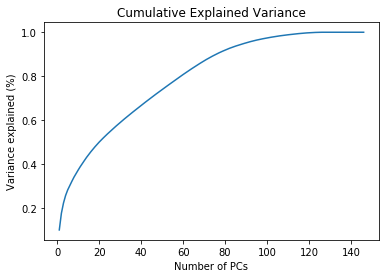

[ 0.1011292   0.17683199  0.22345764  0.25757635  0.28287512  0.30308992
  0.32235124  0.34107638  0.35776602  0.37356096  0.3889216   0.40329853
  0.41727853  0.43108607  0.44380272  0.45615566  0.46778579  0.47915736
  0.49013767  0.50042404  0.51030166  0.51976866  0.52910465  0.53813352
  0.54697234  0.55576252  0.5643584   0.57289184  0.58121909  0.58948982
  0.59760959  0.60566937  0.61358624  0.62139717  0.62915914  0.63684594
  0.64446767  0.6520485   0.65960832  0.66708785  0.67455026  0.6819987
  0.6893419   0.69665398  0.70391176  0.71110401  0.71826879  0.72534009
  0.73235752  0.7393592   0.74631516  0.7532614   0.76014554  0.76701488
  0.77387191  0.78071898  0.78755436  0.79435476  0.8011143   0.80782632
  0.81443261  0.82095738  0.82742877  0.83370257  0.83993333  0.84613269
  0.85227425  0.85828142  0.86419325  0.87005617  0.87570075  0.88116123
  0.88639408  0.89154292  0.89647057  0.90131394  0.90596611  0.91043468
  0.91462996  0.91877592  0.92279914  0.92668045  0.

In [33]:
# Investigate the variance accounted for by each principal component.
plt.plot(range(1,len(pca.explained_variance_ratio_)+1),np.cumsum(pca.explained_variance_ratio_), '-')
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of PCs")
plt.ylabel("Variance explained (%)")
plt.show()
print(np.cumsum(pca.explained_variance_ratio_))

In [34]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca2 = PCA(n_components=100)
azdias_2below_pca = pca2.fit_transform(azdias_2below_pp)

print("Total variance explained (%) by PCA = {}".format(np.cumsum(pca2.explained_variance_ratio_*100)[-1]))

Total variance explained (%) by PCA = 97.40734831947005


### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

Response:
    PCA was first apllied to the data using the maximum number of Principal Components that is possible (i.e. max. num. of PCs = total number of features). The plot showing the cummulative variance explained by the PCs reveals a plateau profile after 100 PCs, which means the explained variance by the PCs after the 100th is practically equal to zero. Therefore, the data was reduced to 100 variables after applying PCA using no more than 100 PCs (total variance of the data explained by PCA equal to 97.41%). 
    Note that individual PCs explaining only small fractions of the data is an indication that the features are highly uncorrelated, otherwise the same total ammount of variance could have been explained by using much less PCs.  

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [35]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def pca_weights(pca, comp, df_raw):
    # df_raw refers to the Df containing the original features
    
    df = pd.DataFrame(pca.components_, columns=list(df_raw.columns))
    weights = df.iloc[comp-1].sort_values(ascending=False)
    return weights


In [36]:
# Map weights for the first  principal component to corresponding feature names
# and then print the linked values, sorted by weight.

print(pca_weights(pca2, 1, azdias_2below))

LP_STATUS_GROB_1.0       0.197490
HH_EINKOMMEN_SCORE       0.184254
PLZ8_ANTG3               0.181192
WEALTH                   0.178594
PLZ8_ANTG4               0.175737
ORTSGR_KLS9              0.153352
EWDICHTE                 0.151416
FINANZ_HAUSBAUER         0.142769
FINANZ_SPARER            0.133599
KBA05_ANTG4              0.127901
LP_STATUS_FEIN_1.0       0.126095
FINANZTYP_1              0.122185
PLZ8_ANTG2               0.122153
LP_STATUS_FEIN_2.0       0.120386
KBA05_ANTG3              0.117294
ANZ_HAUSHALTE_AKTIV      0.115355
ARBEIT                   0.112986
CAMEO_DEUG_2015_9        0.109692
MOVEMENT                 0.107366
RELAT_AB                 0.104391
SEMIO_PFLICHT            0.098631
GENERATION               0.097089
SEMIO_REL                0.093311
CAMEO_DEUG_2015_8        0.088425
ZABEOTYP_5               0.087767
SEMIO_RAT                0.085888
LP_FAMILIE_GROB_1.0      0.083348
LP_FAMILIE_FEIN_1.0      0.083348
SEMIO_TRADV              0.083113
FINANZ_UNAUFFA

In [37]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

print(pca_weights(pca2, 2, azdias_2below))

ALTERSKATEGORIE_GROB     0.225909
FINANZ_VORSORGER         0.208044
ZABEOTYP_3               0.201062
SEMIO_ERL                0.184635
RETOURTYP_BK_S           0.159299
SEMIO_LUST               0.157939
LP_STATUS_FEIN_1.0       0.112314
FINANZ_HAUSBAUER         0.102098
CJT_GESAMTTYP_2.0        0.101171
FINANZTYP_5              0.094476
PLZ8_ANTG3               0.087101
SEMIO_KRIT               0.086004
PLZ8_ANTG4               0.083360
EWDICHTE                 0.081573
ORTSGR_KLS9              0.081030
FINANZTYP_2              0.078921
SHOPPER_TYP_3.0          0.076263
WEALTH                   0.075354
SEMIO_KAEM               0.069902
CJT_GESAMTTYP_1.0        0.067590
KBA05_ANTG4              0.066912
FINANZ_MINIMALIST        0.065376
FINANZTYP_6              0.064291
LP_FAMILIE_GROB_1.0      0.064023
LP_FAMILIE_FEIN_1.0      0.064023
ARBEIT                   0.061931
ANZ_HAUSHALTE_AKTIV      0.059580
PLZ8_ANTG2               0.059061
GFK_URLAUBERTYP_4.0      0.058698
RELAT_AB      

In [38]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

print(pca_weights(pca2, 3, azdias_2below))


SEMIO_VERT               0.322674
SEMIO_FAM                0.258289
SEMIO_SOZ                0.257482
SEMIO_KULT               0.245632
FINANZTYP_5              0.138136
FINANZ_MINIMALIST        0.132076
SHOPPER_TYP_0.0          0.122404
SEMIO_REL                0.114004
ZABEOTYP_1               0.111325
RETOURTYP_BK_S           0.089609
SEMIO_MAT                0.081266
GREEN_AVANTGARDE         0.069043
ORTSGR_KLS9              0.067602
EWDICHTE                 0.067540
FINANZ_VORSORGER         0.054073
PLZ8_ANTG4               0.053599
PLZ8_ANTG3               0.053063
ZABEOTYP_6               0.052100
LP_STATUS_FEIN_1.0       0.051125
LP_STATUS_FEIN_10.0      0.048742
LP_STATUS_GROB_5.0       0.048742
LP_STATUS_FEIN_3.0       0.043610
SHOPPER_TYP_1.0          0.042499
RELAT_AB                 0.038366
PLZ8_ANTG2               0.038035
ARBEIT                   0.036245
SEMIO_LUST               0.033170
LP_STATUS_GROB_3.0       0.032416
GEBAEUDETYP_3.0          0.031667
GFK_URLAUBERTY

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

Response:
    The weights from the first 3 PCs were extracted from the PCA model. Considering that the PCs are sorted in descending order of explained variance in a PCA model, the PC1 capturing most of the variance in the data shows higher importance for the LP_STATUS_GROB variable (level = 1), with positive correlation with HH_EINKOMMEN_SCORE and PLZ8_ANTG3. Conversely, these features have negative correlation with features such as FINANZ_MINIMALIST and MOBI_REGIO, which means these uncorrelated features may represent different types of potential customers. Note that not excluding the categorical feature LP_STATUS_GROB, but instead performing one-hot-encoding, was important to extract relevant information from that feature in the data. Features with PC weights closer to zero infer lower importance of that feature for the variance captured by the respective PC.  
    Similar interpretations can be obtained when inspecting the weights of the features from the remaining PCs, which will gradatively explain less of the total variance in the data.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [41]:
from sklearn.cluster import KMeans

max_k = 20
kmeans_scores = []
# Over a number of different cluster counts...
for k in list(range(2,max_k,2)):
    
    # run k-means clustering on the data and...
    model = KMeans(n_clusters=k).fit(azdias_2below_pca)
    
    # compute the average within-cluster distances.
    kmeans_scores.append(np.abs(model.score(azdias_2below_pca)))
    
    print("Num. of Clusters = {}, Score = {}".format(k,kmeans_scores[-1]))

Num. of Clusters = 2, Score = 94228061.17582896
Num. of Clusters = 4, Score = 87440987.32841885
Num. of Clusters = 6, Score = 83860634.23993744
Num. of Clusters = 8, Score = 81468057.29781176
Num. of Clusters = 10, Score = 79415302.38490425
Num. of Clusters = 12, Score = 77972087.08792134
Num. of Clusters = 14, Score = 76586096.91536914
Num. of Clusters = 16, Score = 75415813.7454677
Num. of Clusters = 18, Score = 74660484.35860768


Text(0,0.5,'Score')

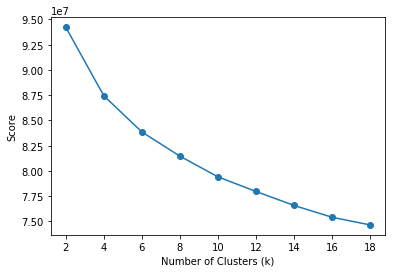

In [43]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(list(range(2,max_k,2)), kmeans_scores, linestyle='-', marker='o')
plt.xlabel('Number of Clusters (k)');
plt.ylabel('Score')


In [45]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters=10).fit(azdias_2below_pca)

kmeans_pred = kmeans_model.predict(azdias_2below_pca)


### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

Response:
    The decision for the total number of clusters in the KMeans model equals to 10 for this dataset was made based on the plot describing the score value from KMeans models fitted with number of clusters varying from 2 to 18. This decision was based on the trade-off between enhancing the clusters separation (high score), but at the same time spliting the data into more clusters in order to better fullfill the project's goals, i.e. targeting more especific groups of customers.
    Therefore, it is important to mention the decision about the number of clusters in a KMeans models can also have a subjectivity component that requires the understanding of the data, in order that the best KMeans model can be fitted to address to the project's ambitions.  

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [46]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [47]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Applying cleaning function
customers = clean_data(customers, feat_info)

# Checking for consistency in the features between GENERAL demographics data and CUSTOMER data 
feat = np.setdiff1d(azdias_2below.columns,customers.columns).tolist()
print(feat)
if feat:
    azdias_2below_pp = azdias_2below_pp.drop(columns=feat)

print("Shape of General data is {}".format(azdias_2below_pp.shape))
print("Shape of Customer data is {}".format(customers.shape))


['GEBAEUDETYP_5.0']
Shape of General data is (719624, 145)
Shape of Customer data is (128989, 145)


In [48]:
# re-fittig PCA and KMeans after exclusing features in GENERAL not presented in CUSTOMER

pca = PCA(n_components=100)

azdias_2below_pca = pca.fit_transform(azdias_2below_pp)

kmeans_model = KMeans(n_clusters=10).fit(azdias_2below_pca)

kmeans_pred = kmeans_model.predict(azdias_2below_pca)


In [49]:
# Preprocesing in Customers Data

# Data imputation
customers_pp = imp.fit_transform(customers)

# AutoScaling
scaler = StandardScaler()
customers_pp = scaler.fit_transform(customers_pp)

# Dimensionality reduction using PCA model
customers_pca = pca.transform(customers_pp)

# Applying KMeans model for cluster predictions
customers_pred = kmeans_model.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0.5,1,'General Population Clusters')

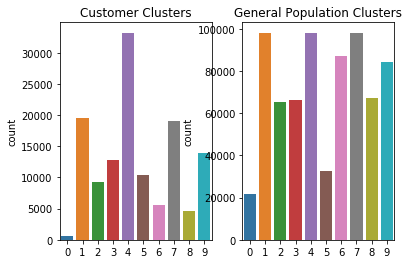

In [50]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
fig, axs = plt.subplots(nrows=1, ncols=2)

sns.countplot(customers_pred, ax=axs[0]) 
axs[0].set_title('Customer Clusters')
sns.countplot(kmeans_pred, ax=axs[1])
axs[1].set_title('General Population Clusters')


In [51]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
k4 = scaler.inverse_transform(pca.inverse_transform(kmeans_model.cluster_centers_[4]))
overrep = pd.Series(data = k4, index = customers.columns).sort_values(ascending=False)
print(overrep)


MIN_GEBAEUDEJAHR        1992.683455
KBA13_ANZAHL_PKW         744.669615
WOHNDAUER_2008             9.042775
SEMIO_LUST                 6.099131
SEMIO_VERT                 5.553267
FINANZ_MINIMALIST          5.396129
SEMIO_ERL                  5.217222
INNENSTADT                 5.014315
ORTSGR_KLS9                4.955820
FINANZ_VORSORGER           4.910763
MOBI_REGIO                 4.774417
KBA05_GBZ                  4.502047
SEMIO_SOZ                  4.346534
BALLRAUM                   4.324703
GEBAEUDETYP_RASTER         4.146886
PLZ8_GBZ                   4.115225
SEMIO_DOM                  4.086278
RETOURTYP_BK_S             4.070068
LIFE_STYLE                 4.027395
ALTERSKATEGORIE_GROB       3.793723
EWDICHTE                   3.752748
SEMIO_KRIT                 3.683342
PLZ8_HHZ                   3.677952
KONSUMNAEHE                3.586225
SEMIO_KULT                 3.565226
KBA05_ANTG1                3.529171
SEMIO_KAEM                 3.469416
SEMIO_FAM                  3

In [53]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
k6 = scaler.inverse_transform(pca.inverse_transform(kmeans_model.cluster_centers_[6]))
underrep = pd.Series(data = k6, index = customers.columns).sort_values(ascending=False)
print(underrep)



MIN_GEBAEUDEJAHR        1992.310247
KBA13_ANZAHL_PKW         609.684334
ANZ_HAUSHALTE_AKTIV        9.224915
WOHNDAUER_2008             8.228222
ORTSGR_KLS9                6.290919
SEMIO_DOM                  5.605217
SEMIO_KAEM                 5.361009
SEMIO_KRIT                 4.892097
SEMIO_RAT                  4.821917
EWDICHTE                   4.731513
SEMIO_ERL                  4.578585
SEMIO_TRADV                4.538358
SEMIO_LUST                 4.505486
HH_EINKOMMEN_SCORE         4.383532
SEMIO_PFLICHT              4.335406
SEMIO_MAT                  4.332557
SEMIO_REL                  4.150444
GENERATION                 4.150104
INNENSTADT                 3.990994
SEMIO_KULT                 3.916389
FINANZ_VORSORGER           3.811020
FINANZ_HAUSBAUER           3.785661
PLZ8_HHZ                   3.774402
BALLRAUM                   3.670950
SEMIO_FAM                  3.648118
GEBAEUDETYP_RASTER         3.635910
SEMIO_SOZ                  3.446467
WEALTH                     3

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

Response:

The plots demonstrates that the potential customers for the company belong to the clusters 4, 1, 7 and 9 (descending order).

For cluster number 4, the company is prosperous with customers with higher scores for "KBA13_ANZAHL_PKW" and "MOBI_REGIO".

Conversely, the company is not strong for customers in cluster 6, which can be described in terms of the higher scores for "HH_EINKOMMEN_SCORE" and "ANZ_HAUSHALTE_AKTIV ".

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.